# Object Detection

In tutti gli esercizi affrontati nelle lezioni precedenti, il task considerato è sempre stato quello di classificare una data istanza (un'immagine nel caso delle CNN, o un'array di features nel caso delle ANN). 

Focalizzando l'attenzione al caso delle immagini, esistono altri possibili task che possono essere affrontati. Tra questi, l'object detection, ossia l'individuazione degli oggetti in un'immagine, è probabilmente il più immediato e naturale passo avanti. Il problema è infatti estremamente simile, in quanto si tratta sempre di analizzare il contenuto di un'immagine per poi poter associare una classe alla stessa. La differenza sostanziale è che mentre nella classificazione bisogna associare una label (classe) all'intera immagine, nel caso della object detection lo scopo è quello di associare delle label (classi) a porzioni dell'immagine. 

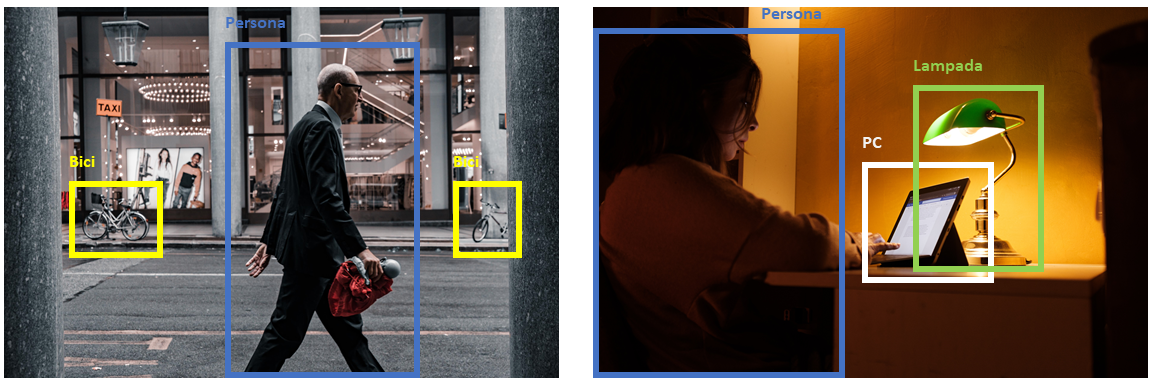

Come si vede nell'immagine di esempio, la conseguenza più immediata è che nel caso della object detection c'è la possibilità che siano presenti più oggetti, aventi eventualmente differenti labels, nella stessa immagine. 

Passare dalla classificazione alla detection può essere effettuato in vari modi. In questa lezione vedremo alcune possibilità, analizzando dapprima come varia le generazione del dataset e come cambiano le metriche di performance da considerarsi.

## Caricamento di dataset per la object detection

I dataset utilizzati nelle lezioni precedenti consistevano in una serie di campioni e le classi associati agli stessi. Per poter effettuare la detection delle parti in un'immagine, è invece necessario avere l'elenco degli oggetti di interesse presenti nella scena e le coordinate dei box che li contengono. È importante evidenziare due note a riguardo:

*   Non tutti gli oggetti presenti in una scena potrebbero essere di interesse per il task in esame. Difatti, cosi come nei problemi di classficazione il numero di classi è comunque limitato rispetto alla realtà (ad esempio le otto categorie sportive), anche nell'object detection solo una parte di tutti gli oggetti esistenti è catalogata ed usata per lo scopo
*   Esistono numerose diverse convenzioni per indicare i box associati ad un oggetto in una scena. Quello usato in PyTorch consiste in una tupla di quattro elementi, rappresentanti i due valori minimo e massimo per ognuno dei due assi

Per chiarire meglio questi aspetti, vediamoli praticamente considerando il dataset [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), un famoso dataset per la object detection di immagini naturali. 



In [ ]:
##########################################################
#                                                        #
# L'esecuzione della cellla può richedere diversi minuti #
#                                                        #
##########################################################

import torch
import torchvision
import torchvision.datasets as datasets
import os
import patoolib


#Estrazione del dataset dalla cartella di lavoro locale
os.mkdir('vocDET')
patoolib.extract_archive("VOCtrainval_06-Nov-2007.tar", outdir=os.path.join(os.getcwd(), 'vocDET'))

#Caricamento dataset
vocTraining = datasets.VOCDetection('vocDET', year='2007', image_set='train')

#Estrazione di un campione
campione = vocTraining.__getitem__(10)

#Stampa delle info contenute
print(type(campione))
print(campione)

#Estrazione dell'immmagine, dei box e delle label contenuti nel campione
img = campione[0]
annotazione = campione[1]['annotation']
oggetti = annotazione['object']
print('Numero di oggetti presenti: {}'.format(len(oggetti)))

#Visualizzazione del contenuto di annotazioni e oggetti
print(annotazione)
print(oggetti)

Il dataset VOC è presente tra quelli forniti con torchvision, dunque possiamo scaricarlo ed usarlo come fatto negli altri casi. Le differenze iniziano però ad essere evidenti quando si accede ad uno dei campioni. In questo caso, l'oggetto restituito è una tupla contenente, oltre al dato associato all'immagine (in posizione 0), tutta una serie di informazioni e metadati. Tra queste, è presente una lista di annotazioni, ossia l'insieme dei box che identificano le porzioni dell'immagine (uno per ognuno degli oggetti presenti nella scena) e il corrispondente insieme delle classi. 

Il codice seguente permette di visualizzare uno qualsiasi di questi campioni, insieme a tutti i box (e label) ad esso associati. Dato che l'operazione di visualizzazione ci tornerà utile anche più avanti, la racchiudiamo all'interno di una funzione

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def stampaCampioneBox(campione):
  img = np.array(campione[0])
  annotazione = campione[1]['annotation']
  oggetti = annotazione['object']
  for o in oggetti:
    classe = o['name']
    coordinate = o['bndbox']
    x_min = int(coordinate['xmin'])
    y_min = int(coordinate['ymin'])
    x_max = int(coordinate['xmax'])
    y_max = int(coordinate['ymax'])
    box = (x_min, y_min, x_max, y_max)

    #Visualizzazione
    plt.imshow(img)

    #Aggiunta del rettangolo e della label
    rect = Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1,edgecolor='y',facecolor='none')
    plt.gca().add_patch(rect)
    plt.gca().text(x_min + 5, y_min + 25, classe, size=20, color='y')

#Visualizzazione del campione estratto precedentemente
stampaCampioneBox(campione)

Implementare la funzione di visualizzazione di un campione (e dei relativi box) permette di toccare con mano le differenze, accennate precedentemente, rispetto al caso della classificazione. In particolare, la funzione `stampaCampioneBox` estrare un box per ognuno degli oggetti presenti tra le annotazioni, sovrapponendo gli stessi all'immagine originale e aggiungendo il nome della classe (label) ad ognuno di essi. 

A questo punto, abbiamo tutte le informazioni necessarie per realizzare la funzione di caricamento del dataset, da utilizzarsi poi insieme al dataloader al fine di preparare in maniera corretta il batch di addestramento.

Difatti, come detto all'inizio della lezione, nel caso dell'object detection ogni immagine contiene un numero variabile di oggetti (1+). Ne consegue che la gestione dei batch non è immediata, in quanto il numero di oggetti (e quindi di box e label) presenti nelle immagini contenute nel batch non è predicibile a priori. Per ovviare al problema definiamo una funzione *aggregaCampioni* al fine di indicare come combinare tra di lori i tensori aventi dimensioni differenti. 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.transforms.functional as FT

#Mappe di conversione tra indici e valore testuale delle classi per il dataset VOC
classiVoc = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
labelIdx = {k: v + 1 for v, k in enumerate(classiVoc)}
labelIdx['background'] = 0
idxLabel = {v: k for k, v in labelIdx.items()} 

#Mappa di colori 
colori = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
mapppaColori = {k: colori[i] for i, k in enumerate(labelIdx.keys())}

#Funzione per aggregare i dati
def aggregaCampioni(batch):
  #Liste usate per raggruppare in modo omogeneo i dati  
  immagini = list()
  boxes = list()
  classi = list()

  #Estrazione delle immagini, box e label da ogni campione b presente in un batch
  for b in batch:
    img = b[0]

    annotazione = b[1]['annotation']
    oggetti = annotazione['object']

    #Variabili temporanee di appoggio per i box e le label del campione corrente
    tempBox = np.empty((0,4));  
    tempClassi = []

    #Estrazione di tutti i box e le label del campione corrente
    for o in oggetti:
      classe = o['name']
      coordinate = o['bndbox']
      x_min = int(coordinate['xmin'])
      y_min = int(coordinate['ymin'])
      x_max = int(coordinate['xmax'])
      y_max = int(coordinate['ymax'])

      #Aggiunta all'elenco dei box e classe
      tempBox = np.append(tempBox, np.array([[x_min, y_min, x_max, y_max]]), axis=0)
      tempClassi = np.append(tempClassi, [labelIdx[classe]], axis=0)

    #Resize dell'immagine e dei box
    dimOrig = torch.FloatTensor([np.float32(img.shape[2]), np.float32(img.shape[1]), np.float32(img.shape[2]), np.float32(img.shape[1])]).unsqueeze(0)
    img = FT.resize(img, (300, 300))
    tempBox = tempBox / dimOrig  #Conversione a coordinare relative (percentuali)

    #Casting a tensore
    tempBox = torch.FloatTensor(np.float32(tempBox))
    tempClassi = torch.LongTensor(tempClassi)

    #Aggiunta dei dettagli del campione attuale, alle liste dei campioni del batch
    immagini.append(img)
    boxes.append(tempBox)
    classi.append(tempClassi)

  #Impilamento di tutte le immagini
  immagini = torch.stack(immagini, dim=0)

  return immagini, boxes, classi 

La funzione *aggregaCampioni* può essere usata nel dataLoader di PyTorch (come valore per il parametro `collate_fn`) al fine di indicare al dataloader come assemblare correttamente immagini, box e classi dei campioni di un dato batch. 

Si noti che abbiamo usato alcune variabili di appoggio per la gestione della conversione delle classi da stringa a valore numerico. Questa cosa è analoga a quanto fatto nelle precedenti lezioni attraverso il metodo `class_to_idx`. In questo caso specifico, essendo importante tenere traccia del mapping bidirezionale tra indice e classe "testuale", è preferibile provvedere manualmente. Abbiamo quindi approfittato di questa necessità per aggiungere una label che indichi lo sfondo (background) e la mappa dei colori da associare ai box, per ogni label. 

A questo punto possiamo costruire i dataloader per training, validation e test, cosi come fatto nelle precedenti lezioni.


In [ ]:
##########################################################
#                                                        #
# L'esecuzione della cella può richedere diversi minuti  #
#                                                        #
##########################################################

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)

#Caricamento delle immagini
trasf = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

os.mkdir('vocDET_Train')
patoolib.extract_archive("VOCtrainval_06-Nov-2007.tar", outdir=os.path.join(os.getcwd(), 'vocDET_Train'))
trainingSet = datasets.VOCDetection('vocDET_Train', year='2007', image_set='train', download=False, transform=trasf)

os.mkdir('vocDET_Test')
patoolib.extract_archive("VOCtest_06-Nov-2007.tar", outdir=os.path.join(os.getcwd(), 'vocDET_Test'))
testSet = datasets.VOCDetection('vocDET_Test', year='2007', image_set='test', download=False, transform=trasf)

#Parametri dataloader
dimBatchTrain = 16
dimBatchVal = 64
dimBatchTest = 64

#Creazione dei dataloader
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.01)
trainingLoader = torch.utils.data.DataLoader(trainingSet, batch_size=dimBatchTrain, shuffle=True, collate_fn=aggregaCampioni)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=False, collate_fn=aggregaCampioni)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=False, collate_fn=aggregaCampioni)

Come si vede dal codice riportato, la sequenza di operazioni (e il modo in cui queste sono fatte) è praticamente identica a quanto fatto nel caso della classificazione (considerando anche che il resize dell'immagine è gestito dalla funzione `aggregaCampioni`).

Si noti che abbiamo scaricaro nuovamente anche il training set solo per fini didattici (il codice è più lineare). Avremmo potuto usare senza problemi quello già scaricato precedentemente. Infine, il validation è scelto cosi piccolo solo per questioni prestazionali (come vedremo alla fine della lezione).

## Valutazione delle prestazioni nella object detection

Nei precedenti esercizi di classificazione abbiamo uso l'accuracy come metrica di performance, al fine di misurare quante volte il nostro modelllo fosse in grado di determinare la classe corretta per il cammpione in esame. Nel caso della object detection questa operazione non è altrettanto banale per due motivi:

*   La presenza di più oggetti nella scena
*   La necessità di misurare quanto bene il box predetto si sovrapponga al box effettivo

Per capire meglio le differenze, consideriamo l'immagine seguente: in blu è riportato il box "vero" (noto anche come **ground truth**), ossia il box "perfetto", così come definito da chi ha creato il dataset; in verde la predizione fatta da un ipotetico modello *m1*; e in rosso la predizione fatta da un secondo ipotetico modello *m2*.

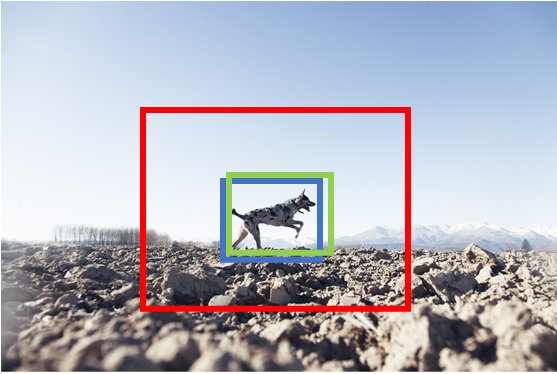

L'esempio riportato mostra quanto il secondo punto sia il più critico tra i due. Difatti, supponendo che in entrambi i casi la classe (label) predetta sia corretta, se non si tiene in conto anche della bontà di sovrapposizione tra il box predetto e quello vero, entrambi i modelli risulterebbero essere ugualmente buoni, quando invece il modello *m1* è chiaramente preferibile.

Tenere in conto la bontà di sovrapposizione implica la necessità di misurare quantiativamente quanto il box predetto e il box vero siano simili. A tal scopo è possibile utilizzare differenti indici di similarità o di sovrapposizione, metriche progettate appunto per misurare e quantificare le porzioni di sovrapposizione e di scarto tra due box.

Nel caso della object detection, uno dei più utilizzati è l'indice di Jaccard, definito come $J = \frac{A \cap B}{A \cup B} $, con A e B due box generici. 

L'indice di Jaccard tiene quindi conto al contempo delle porzioni sovrapposte dei box, ma anche di quelle che non si sovrappongono. Dato il modo in cui è definito, $J \in [0,1]$ con 0 indicativo di due box completamente disgiunti e 1 indicativo di due box perfettamente sovrapposti. Applicando tale indice all'esempio di prima, l'output del modello *m2* sarebbe fortemente penalizzato dalla vasta aria di non sovrapposizione, permettendo quindi di far emergere il modello *m1* come preferibile.

L'indice di Jaccard sarà uno dei fulcri del modello di object detection che definiremo a breve. Progettiamo quindi la funzione che lo calcola, dati in ingresso due set di box (predetto e vero). Concettualmente la funzione opera esattamente come descritto, con la sola differenza di considerare più box contemporaneamente (dato che il dataset considerato prevede la possibilità di avere più oggetti in una stessa scena).

In [ ]:
def jaccardIndex(boxVeri, boxPredetti):
    #Individuazione di tutte le possibili intersezioni tra i box
    LB = torch.max(boxVeri[:, :2].unsqueeze(1), boxPredetti[:, :2].unsqueeze(0))  #Limiti inferiori dei match
    UB = torch.min(boxVeri[:, 2:].unsqueeze(1), boxPredetti[:, 2:].unsqueeze(0))  #Limiti superiori dei match
    dimIntersezioni = torch.clamp(UB - LB, min=0)                        
    intersezioni = dimIntersezioni[:, :, 0] * dimIntersezioni[:, :, 1]   

    #Calcolo delle unioni
    areeBoxVeri = (boxVeri[:, 2] - boxVeri[:, 0]) * (boxVeri[:, 3] - boxVeri[:, 1])  
    areeBoxPredetti = (boxPredetti[:, 2] - boxPredetti[:, 0]) * (boxPredetti[:, 3] - boxPredetti[:, 1])
    unioni = areeBoxVeri.unsqueeze(1) + areeBoxPredetti.unsqueeze(0) - intersezioni  

    #Calcolo dell'indice per tutti i box
    return intersezioni / unioni 

L'indice di Jaccard è utile per misurare la soprapposizione di due box. Tuttavia, misurare le performance di un algoritmo di object detection necessita di tener in considerazione anche

*   della classe assegnata ai box correttamente predetti 
*   dei box che invece, sebbene prodotti in output, non contengono alcun oggetto

La metrica più utilizzata per valutare le performance di algoritmi di object detection è la mean Average Precision (mAP). La mAP è data dalla media, su tutte le classi, della Average Precision. Quest'ultima è definita come l'area sotto la curva precision-recall. Precision e recall misurano rispettivamente l'esattezza (o fedeltà) e la completezza delle predizioni. Nel nostro caso una predizione è considerata corretta se l'indice di Jaccard è maggiore di una data soglia, tipicamente 0.5.

In [ ]:
def calcolaMAP(boxPredetti, classiPredette, scorePredizioni, boxVeri, labelVere):

    #Codice preliminare di supporto
    numClassi = len(labelIdx)
    oggettiCorretti = list()
    for i in range(len(labelVere)):
        oggettiCorretti.extend([i] * labelVere[i].size(0))
    oggettiCorretti = torch.LongTensor(oggettiCorretti).to(device) 
    boxVeri = torch.cat(boxVeri, dim=0) 
    labelVere = torch.cat(labelVere, dim=0) 
    oggettiPredetti = list()
    for i in range(len(classiPredette)):
        oggettiPredetti.extend([i] * classiPredette[i].size(0))
    oggettiPredetti = torch.LongTensor(oggettiPredetti).to(device) 
    boxPredetti = torch.cat(boxPredetti, dim=0)  
    classiPredette = torch.cat(classiPredette, dim=0)  
    scorePredizioni = torch.cat(scorePredizioni, dim=0) 

    #Calcolo della Average Precision per ogni classe
    AP = torch.zeros((numClassi - 1), dtype=torch.float) 
    for c in range(1, numClassi):
        immaginiCorrette = oggettiCorretti[labelVere == c]  
        boxesCorretti = boxVeri[labelVere == c]  
        numOggetti = boxesCorretti.size(0)  
        boxesPredettiCorretti = torch.zeros((boxesCorretti.size(0)), dtype=torch.uint8).to(device) 

        classiPredetteOggetti = oggettiPredetti[classiPredette == c]  
        classiPredetteBoxes = boxPredetti[classiPredette == c]  
        classiPredetteScores = scorePredizioni[classiPredette == c]  
        numClassiPredette = classiPredetteBoxes.size(0)
        if numClassiPredette == 0:
            continue

        classiPredetteScores, indici = torch.sort(classiPredetteScores, dim=0, descending=True) 
        classiPredetteOggetti = classiPredetteOggetti[indici]  
        classiPredetteBoxes = classiPredetteBoxes[indici] 

        TP = torch.zeros((numClassiPredette), dtype=torch.float).to(device) 
        FP = torch.zeros((numClassiPredette), dtype=torch.float).to(device) 
        for d in range(numClassiPredette):
            boxCorrente = classiPredetteBoxes[d].unsqueeze(0) 
            imgCorrente = classiPredetteOggetti[d]  
            boxesCorrenti = boxesCorretti[immaginiCorrette == imgCorrente]  
            if boxesCorrenti.size(0) == 0:
                FP[d] = 1
                continue

            overlaps = jaccardIndex(boxCorrente, boxesCorrenti)  
            maxOverlap, ind = torch.max(overlaps.squeeze(0), dim=0) 
            indIniziale = torch.LongTensor(range(boxesCorretti.size(0)))[immaginiCorrette == imgCorrente][ind]
            if maxOverlap.item() > 0.5:
                if boxesPredettiCorretti[indIniziale] == 0:
                    TP[d] = 1
                    boxesPredettiCorretti[indIniziale] = 1  
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        #Score cumulativi
        cumTP = torch.cumsum(TP, dim=0) 
        cumFP = torch.cumsum(FP, dim=0) 
        cumPrecision = cumTP / (cumTP + cumFP + 1e-10) #Aggiunta di un eps per evitare divisioni per zero
        cumRecall = cumTP / numOggetti  

        ths = torch.arange(start=0, end=1.1, step=.1).tolist() 
        precisions = torch.zeros((len(ths)), dtype=torch.float).to(device)
        for i, t in enumerate(ths):
            recallsThs = cumRecall >= t
            if recallsThs.any():
                precisions[i] = cumPrecision[recallsThs].max()
            else:
                precisions[i] = 0.
        AP[c - 1] = precisions.mean()  

    #Calcolo della mAP
    mAP = AP.mean().item()

    #Salva la average precisione per classe in un dizionario
    AP = {idxLabel[c + 1]: v for c, v in enumerate(AP.tolist())}

    return AP, mAP

# CNN per la object detection

A questo punto, abbiamo tutti i prerequisiti necessari per implementare un object detector basato su CNN. Sebbene il task di object detection fosse già investigato prima della nascita del deep learning, l'uso delle CNN ha avuto un impatto notevole sulle performance. 

I primissimi esperimenti in tal senso hanno dato vita alle region-based convolutional neural network (R-CNN). L'idea di base era quella di continuare a seguire i passi usati dagli algoritmi di object detection tradizionali (ossia individuazione di regioni candidate, estrazione di features per le regioni candidate e classificazione delle stesse) sfruttando però la capacità delle CNN di estrarre features efficaci. 

Da questa prima soluzione (intuitiva, ma computazionalmente molto onerosa e non particolarmente efficace e scalabile), negli anni sono state proposte un'ampia varietà di architetture, alcune più incentrate sulla scalabilità, altre sulle performance. Tra tutte, una delle più interessanti (da un punto di vista didattico) è l'architettura nota come SSD (acronimo di Single Shot MultiBox Detector). 

## SSD300

Una delle caratteristiche principali di SSD è la capacità di effettuare la fase di localizzazione (ossia estrazione delle regioni) e assegnazione delle classi in un'unica operazione, in quello che è tecnicamente noto come end-to-end training. L'idea alla base di SSD è quella di ri-utilizzare i layer convoluzionali di una CNN (eventualmente pre-addestrata) insieme ad altri layer convoluzionali esplicitamente progettati per effettuare l'operazione di detection. 

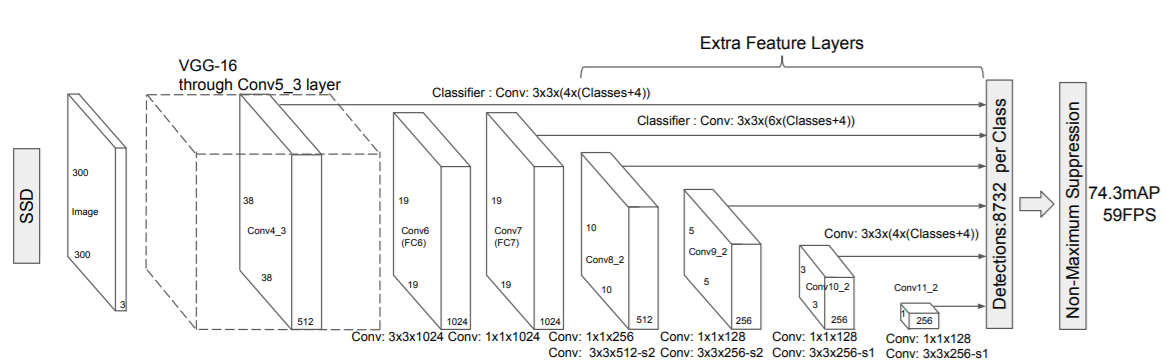


Come si vede dall'immagine (presa direttamente dalla [pubblicazione scientifica](https://arxiv.org/pdf/1512.02325.pdf) in cui SSD è stato presentato), SSD è una rete che presenta solo layer convoluzionali, facilmente raggruppabili in tre gruppi:

*   Un set di layers convoluzionali prelevati da una CNN pre-esistente, da usarsi come estrattori di features a basso livello. Questi layer sono (praticamente sempre) prelevati da una rete pre-addestrata. Sono comunemente indicati come layer di convoluzioni di base
*   Un set di layers convoluzionali ausiliari che, collegati subito dopo quelli base, apprendono come estrarre features di più alto livello
*   Un set di layers convoluzionali destinati alla detection vera e propria, sulla base delle feature maps generate dai layers precedenti

Al valle di tutti i layers convoluzionali, SSD prevede un'operazione di Non-Maximum Suppression, ossia di eliminazione di alcuni box individuati. Questo passaggio è necessario in quanto l'architettura può dar vita a molte regioni preliminari per uno stesso oggetto. L'uso della Non-Maximum Suppression permette di eliminare queste predizioni ridondanti, andando a sopprimere tutte le predizioni (di uno stesso oggetto) tranne quella con lo score (punteggio) più alto.

Di seguito il codice per implementare il modello SSD cosi come descritto. In particolare, la versione che implementeremo è SSD300, ossia un SSD che riceve in ingresso immagini di 300x300 pixel (e questa è la ragione per cui abbiamo effettuato il resize durante la generazione del dataset). Partiremo con il definire le reti componenti i tre gruppi di layers convoluzionali, per poi da li implementare la rete SSD300 come composizione delle precedenti. Per una più semplice lettura, i vari componenti saranno implementati in celle differenti, in alcuni casi intervalllate da considerazioni e spiegazioni atte a illustrare alcuni aspetti alla base delle scelte fatte. Tutte queste scelte sono di natura puramente didattica, in quanto la rete potrebbe essere implementata in un'unica classe e velocemente modificata per gestire input più grandi di 300x300 pixel. 

In [ ]:
from torch import nn
import torch.nn.functional as funct
from math import sqrt
from itertools import product as product

#Funzione per l'estrazione campionata di pesi pre-addestrati
def campionaPesi(pesi, fattori):
    for k in np.arange(pesi.ndim):
        if fattori[k] is not None:
            pesi = pesi.index_select(dim=k, index=torch.arange(start=0, end=pesi.size(k), step=fattori[k]).long())
    return pesi

#Rete da cui estrarre i layer convoluzionali del gruppo base
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        #Struttura classica di Vgg16, a meno di piccole variazioni su stride, kernel, round, etc.
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True) 

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  

        #Variazione introdotta: sostituzione dei due layer densi con altrettanti convoluzionali
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        #Caricamento (e adattamento) dei pesi pre-addestratti
        state_dict = self.state_dict()
        nomiParmetri = list(state_dict.keys())
        state_dictPreT = torchvision.models.vgg16(pretrained=True).state_dict()
        nomiParmetriPreT = list(state_dictPreT.keys())
        for i, param in enumerate(nomiParmetri[:-4]): 
            state_dict[param] = state_dictPreT[nomiParmetriPreT[i]]

        #Inizializzazione dei pesi degli ultimi due filtri convoluzionali a partire dai pesi dei layer fully connected pre-addestrati 
        preTFc6Weight = state_dictPreT['classifier.0.weight'].view(4096, 512, 7, 7)
        preTFc6Bias = state_dictPreT['classifier.0.bias'] 
        state_dict['conv6.weight'] = campionaPesi(preTFc6Weight, fattori=[4, None, 3, 3]) 
        state_dict['conv6.bias'] = campionaPesi(preTFc6Bias, fattori=[4]) 
        preTFc7Weight = state_dictPreT['classifier.3.weight'].view(4096, 4096, 1, 1) 
        preTFc7Bias = state_dictPreT['classifier.3.bias'] 
        state_dict['conv7.weight'] = campionaPesi(preTFc7Weight, fattori=[4, 4, None, None])  
        state_dict['conv7.bias'] = campionaPesi(preTFc7Bias, fattori=[4])  

        #Aggiornamento dei pesi
        self.load_state_dict(state_dict)

    def forward(self, img):
        x = funct.relu(self.conv1_1(img))  
        x = funct.relu(self.conv1_2(x)) 
        x = self.pool1(x)

        x = funct.relu(self.conv2_1(x))  
        x = funct.relu(self.conv2_2(x)) 
        x = self.pool2(x)  

        x = funct.relu(self.conv3_1(x)) 
        x = funct.relu(self.conv3_2(x)) 
        x = funct.relu(self.conv3_3(x))  
        x = self.pool3(x) 

        x = funct.relu(self.conv4_1(x)) 
        x = funct.relu(self.conv4_2(x))  
        x = funct.relu(self.conv4_3(x))  
        outConv4 = x  
        x = self.pool4(x)  

        x = funct.relu(self.conv5_1(x))  
        x = funct.relu(self.conv5_2(x)) 
        x = funct.relu(self.conv5_3(x))  
        x = self.pool5(x) 

        x = funct.relu(self.conv6(x)) 
        outConv7 = funct.relu(self.conv7(x)) 

        #Feature map di basso livello
        return outConv4, outConv7

La rete "base" è una versione modificata di VGG16,, pre-addestrata su ImageNet. Rispetto alla rete VGG16 originale, gli autori di SSD propongono alcune variazioni atte a modificare la dimensione delle feature maps prodotte in alcuni livelli. Inoltre, gli autori sostituiscono i primi due layers densi con altrettanti layers convoluzionali. Tuttvia, questi nuovi layer convoluzionali avranno un numero di neuroni inferiore a quello dei corrispettivi densi. Per poter utilizzare i pesi pre-addestrati della rete è quindi necessario campionare i pesi dei layer densi che si desidera ri-utilizzare (per maggiori dettagli si faccia riferimento al [lavoro originale](https://arxiv.org/pdf/1512.02325.pdf)). Si noti infine che il layer finale è eliminato, in quanto questa rete è utilizzata esclusivamente come estrattore di features. Di conseguenza, la funzione di feed forward è stata modificata per restituire le feature estratte da due differenti layers convoluzionali (che rappresentano due set di feature descrittive di dettagli di basso livello, quali spigoli, curve, linee, e altre figure geometriche ed elementi tessiturali non troppo complessi).

In [ ]:
class convoluzioniAusiliare(nn.Module):
    def __init__(self):
        super(convoluzioniAusiliare, self).__init__()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) 

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) 

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0) 

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        #Inizializzazione con pesi random
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.)

    def forward(self, outConv7):
        x = funct.relu(self.conv8_1(outConv7))
        x = funct.relu(self.conv8_2(x)) 
        outConv8 = x 

        x = funct.relu(self.conv9_1(x))  
        x = funct.relu(self.conv9_2(x))
        outConv9 = x  

        x = funct.relu(self.conv10_1(x)) 
        x = funct.relu(self.conv10_2(x))  
        outConv10 = x 

        x = funct.relu(self.conv11_1(x)) 
        outConv11 = funct.relu(self.conv11_2(x)) 

        #Feature map di alto livello 
        return outConv8, outConv9, outConv10, outConv11

La nomenclatura scelta per questo set di layers segue quella iniziata nella rete base. Difatti, questo set di layers si aggancia ai layers convoluzionali pre-addestrati estratti da Vgg16. In particolare, si noti come la rete elabori (e restituisca) differeti set di features map (questa volta rappresentative di caratteristiche di più alto livello) a partire da  uno degli output (`outConv7`) della rete base.

A questo punto, tutti i layer necessari ad estrarre features sono definiti e collegati tra loro. Il cuore dell'algoritmo SSD è racchiuso nei ragionamenti associati ai layer convoluzionali che si occupano della predizione dei box vera e propria. L'idea di base è abbastanza semplice e si basa su un concetto semplificabile come segue: sebbene (in linea teorica) in una data immagine gli oggetti potrebbero essere presenti in qualsiasi posizione, nella realtà il numero di porzioni di immagine (leggasi come numero di box) in cui un oggetto può "grossomodo" trovarsi è limitato e finito. Tralasciando i dettagli (per i quali si rimanda al [lavoro originale](https://arxiv.org/pdf/1512.02325.pdf)), se questo ragionamento viene iterato per ognuna delle feature maps estratte dai livelli precedenti (che ricordiamo essere interpretabili come rappresentazioni a scala differente degli stessi oggetti), il numero totale di possibili box (nel caso di SSD300) è precisamente pari a 8732. Questi box sono detti "priors", e sono utilizzati come punto di partenza per trovare i veri box contenenti oggetti tramite un processo di regressione. 

In parole povere, i layers del gruppo di predizione usano i box priors come punto di partenza per determinare le coordinate (quindi è un problema di regressione) di box contenenti oggetti. La classe dell'oggetto contenuto è determinata contestualmente, tenendo anche in considerazione la possibilità che quel box non contenga nessun oggetto (classe di background). Ulteriori dettagli in merito saranno forniti insieme alla spiegazione della funzione di loss utilizzata. Prima di arrivare a quel punto, vediamo come i layer di predizione sono strutturati per effettuare tale regressione.

In [ ]:
class convoluzioniDetection(nn.Module):
    def __init__(self, numClassi):
        super(convoluzioniDetection, self).__init__()

        #Numero di classi (ossia di tipologia di oggetti da considerare)
        self.numClassi = numClassi

        #Numero di priors per ognuna delle feature map considerate
        numPriors = {'outConv4': 4, 'outConv7': 6, 'outConv8': 6, 'outConv9': 6, 'outConv10': 4, 'outConv11': 4}

        #Layers che effettueranno la regressione delle coordinate dei box
        self.conv4_regress = nn.Conv2d(512, numPriors['outConv4'] * 4, kernel_size=3, padding=1)
        self.conv7_regress = nn.Conv2d(1024, numPriors['outConv7'] * 4, kernel_size=3, padding=1)
        self.conv8_regress = nn.Conv2d(512, numPriors['outConv8'] * 4, kernel_size=3, padding=1)
        self.conv9_regress = nn.Conv2d(256, numPriors['outConv9'] * 4, kernel_size=3, padding=1)
        self.conv10_regress = nn.Conv2d(256, numPriors['outConv10'] * 4, kernel_size=3, padding=1)
        self.conv11_regress = nn.Conv2d(256, numPriors['outConv11'] * 4, kernel_size=3, padding=1)

        #Layers che effettueranno la classificazione degli oggetti contenuti nei box
        self.conv4_class = nn.Conv2d(512, numPriors['outConv4'] * numClassi, kernel_size=3, padding=1)
        self.conv7_class = nn.Conv2d(1024, numPriors['outConv7'] * numClassi, kernel_size=3, padding=1)
        self.conv8_class = nn.Conv2d(512, numPriors['outConv8'] * numClassi, kernel_size=3, padding=1)
        self.conv9_class = nn.Conv2d(256, numPriors['outConv9'] * numClassi, kernel_size=3, padding=1)
        self.conv10_class = nn.Conv2d(256, numPriors['outConv10'] * numClassi, kernel_size=3, padding=1)
        self.conv11_class = nn.Conv2d(256, numPriors['outConv11'] * numClassi, kernel_size=3, padding=1)

        #Iniziallizzazione con pesi random
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.)

    def forward(self, outConv4, outConv7, outConv8, outConv9, outConv10, outConv11):
        #Dimensione del batch corrente (numero di oggetti totale presenti nelle immagini del batch attuale)
        dimBatchAttuale= outConv4.size(0)

        #Predizione delle coordinate relative (rispetto alle coordinate iniziali) dei box 
        outConv4_regress = self.conv4_regress(outConv4) 
        outConv4_regress = outConv4_regress.permute(0, 2, 3, 1).contiguous()  
        outConv4_regress = outConv4_regress.view(dimBatchAttuale, -1, 4) 

        outConv7_regress = self.conv7_regress(outConv7) 
        outConv7_regress = outConv7_regress.permute(0, 2, 3, 1).contiguous()  
        outConv7_regress = outConv7_regress.view(dimBatchAttuale, -1, 4)  

        outConv8_regress = self.conv8_regress(outConv8) 
        outConv8_regress = outConv8_regress.permute(0, 2, 3, 1).contiguous()  
        outConv8_regress = outConv8_regress.view(dimBatchAttuale, -1, 4) 

        outConv9_regress = self.conv9_regress(outConv9)
        outConv9_regress = outConv9_regress.permute(0, 2, 3, 1).contiguous()  
        outConv9_regress = outConv9_regress.view(dimBatchAttuale, -1, 4)  

        outConv10_regress = self.conv10_regress(outConv10)  
        outConv10_regress = outConv10_regress.permute(0, 2, 3, 1).contiguous()  
        outConv10_regress = outConv10_regress.view(dimBatchAttuale, -1, 4)  

        outConv11_regress = self.conv11_regress(outConv11)  
        outConv11_regress = outConv11_regress.permute(0, 2, 3, 1).contiguous()  
        outConv11_regress = outConv11_regress.view(dimBatchAttuale, -1, 4) 

        #Classificazione degli oggetti contenuti nei box
        outConv4_class = self.conv4_class(outConv4) 
        outConv4_class = outConv4_class.permute(0, 2, 3, 1).contiguous()
        outConv4_class = outConv4_class.view(dimBatchAttuale, -1, self.numClassi) 

        outConv7_class = self.conv7_class(outConv7) 
        outConv7_class = outConv7_class.permute(0, 2, 3, 1).contiguous()  
        outConv7_class = outConv7_class.view(dimBatchAttuale, -1, self.numClassi)

        outConv8_class = self.conv8_class(outConv8) 
        outConv8_class = outConv8_class.permute(0, 2, 3, 1).contiguous() 
        outConv8_class = outConv8_class.view(dimBatchAttuale, -1, self.numClassi) 

        outConv9_class = self.conv9_class(outConv9)  
        outConv9_class = outConv9_class.permute(0, 2, 3, 1).contiguous()  
        outConv9_class = outConv9_class.view(dimBatchAttuale, -1, self.numClassi) 

        outConv10_class = self.conv10_class(outConv10) 
        outConv10_class = outConv10_class.permute(0, 2, 3, 1).contiguous() 
        outConv10_class = outConv10_class.view(dimBatchAttuale, -1, self.numClassi) 

        outConv11_class = self.conv11_class(outConv11) 
        outConv11_class = outConv11_class.permute(0, 2, 3, 1).contiguous()  
        outConv11_class = outConv11_class.view(dimBatchAttuale, -1, self.numClassi)  

        #Concatenazione di tutte le predizioni fatte
        boxPredetti = torch.cat([outConv4_regress, outConv7_regress, outConv8_regress, outConv9_regress, outConv10_regress, outConv11_regress], dim=1) 
        classiPredette = torch.cat([outConv4_class, outConv7_class, outConv8_class, outConv9_class, outConv10_class, outConv11_class], dim=1) 

        return boxPredetti, classiPredette

La struttura dei layer di predizione è molto semplice: ci sono due rami paralleli (uno per la localizzazione dei box e uno per la classificazione del loro contenuto) che, lavorando insieme, effettuano la detection sulla base dei sei gruppi di features estratti dai layer convoluzionali di base e ausiliari. 

Nel codice ci sono due aspetti pratici che meritano una trattazione in più:

*   Il primo è la dimensione variabile del batch. Questa operazione è necessaria in quanto il numero di oggetti presenti nei batch è differente (mentre il numero di immagini è fisso)
*   L'uso di un reshape è necessario per ripristinare l'ordine in cui PyTorch si aspetta di trovare i dati (numero di campioni, altezza, larghezza, canali)

A questo punto abbiamo quasi tutti i componenti necessari per avviare l'addestramento del nostro SSD. Nelle prossime celle vedremo come implementare gli ultimi due tasselli, ossia la funzione di loss e la rete SSD vera e propria che, collegando opportunamente i tre set di layers convoluzionali precedentemente definiti, effettua l'object detection.

Partiamo proprio dalla definizione della loss. Nel caso dell'SSD abbiamo visto come ci sono due task che vengono eseguiti in parallelo, ossia una regressione e una classificazione. Ne consegue, che la loss finale sarà proprio una combinazione di due loss, ognuna progettata per uno dei due task. Il nome con cui è nota la loss risultante nel caso dell'SSD è *MultiBoxLoss*. 

In [ ]:
#################################################
#              Codice di supporto               #
#################################################

def convertiCoordinate(coordinate, conversione):

    #Da coordinate assolute a realtive al centro
    if(conversione == 'box2rel'):
      return torch.cat([(coordinate[:, 2:] + coordinate[:, :2]) / 2, coordinate[:, 2:] - coordinate[:, :2]], 1) 
    elif(conversione == 'rel2box'):
      return torch.cat([coordinate[:, :2] - (coordinate[:, 2:] / 2), coordinate[:, :2] + (coordinate[:, 2:] / 2)], 1)
    else:
      print('convertiCoordinate: opzione non riconosciuta!')
      return coordinate

def codificaCoordinate(coordinate, coordinatePriors, conversione):
    if(conversione == 'codifica'):
      return torch.cat([(coordinate[:, :2] - coordinatePriors[:, :2]) / (coordinatePriors[:, 2:] / 10),  torch.log(coordinate[:, 2:] / coordinatePriors[:, 2:]) * 5], 1) 
    elif(conversione == 'decodifica'):
      return torch.cat([coordinate[:, :2] * coordinatePriors[:, 2:] / 10 + coordinatePriors[:, :2], torch.exp(coordinate[:, 2:] / 5) * coordinatePriors[:, 2:]], 1)  # w, h
    else:
      print('codificaCoordinate: opzione non riconosciuta!')
      return coordinate

#################################################
#     Definizione della funzione di loss        #
#################################################

class MultiBoxLoss(nn.Module):
    def __init__(self, priorsRelativi, threshold=0.5, rapportoDifficili=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priorsRelativi = priorsRelativi
        self.priorsBox = convertiCoordinate(priorsRelativi, 'rel2box')
        self.threshold = threshold
        self.rapportoDifficili = rapportoDifficili
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()                             #Loss regressione
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)   #Loss classificazione

    def forward(self, boxPredetti, classiPredette, boxes, labels):
        dimBatchAttuale = boxPredetti.size(0)
        numPriors = self.priorsRelativi.size(0)
        numClassi = classiPredette.size(2)

        #Pre-allocazione match corretti
        matchBoxes = torch.zeros((dimBatchAttuale, numPriors, 4), dtype=torch.float).to(device) 
        matchClassi = torch.zeros((dimBatchAttuale, numPriors), dtype=torch.long).to(device) 

        #Ciclo di elaborazione per ogni immagine
        for i in range(dimBatchAttuale):
            numOggetti = boxes[i].size(0)
            overlap = jaccardIndex(boxes[i], self.priorsBox) 
            maxOverlap, maxClasse = overlap.max(dim=0)  

            #Fix di match saltati per bassa confidenza
            _, priorOggetti = overlap.max(dim=1) 
            maxClasse[priorOggetti] = torch.LongTensor(range(numOggetti)).to(device)
            maxOverlap[priorOggetti] = 1.

            #Assegnazione delle classi e dei box per ogni prior
            claassiPriors = labels[i][maxClasse]
            claassiPriors[maxOverlap < self.threshold] = 0  #Background se inferiore alla soglia
            matchClassi[i] = claassiPriors
            matchBoxes[i] = codificaCoordinate(convertiCoordinate(boxes[i][maxClasse],'box2rel'), self.priorsRelativi, 'codifica')

        #Elenco dei priors non claassificati come background
        priorsPositivi = matchClassi != 0 

        #Calcolo della loss di regressione
        lossRegress = self.smooth_l1(boxPredetti[priorsPositivi], matchBoxes[priorsPositivi]) 

        #Calcolo della loss di classificazione
        numPriorsPositivi = priorsPositivi.sum(dim=1) 
        numPriorsDifficili = self.rapportoDifficili * numPriorsPositivi  
        lossClassTotale = self.cross_entropy(classiPredette.view(-1, numClassi), matchClassi.view(-1)) 
        lossClassTotale = lossClassTotale.view(dimBatchAttuale, numPriors) 
        lossClassPositivi = lossClassTotale[priorsPositivi]  
        lossClassNegativi = lossClassTotale.clone()  
        lossClassNegativi[priorsPositivi] = 0.  
        lossClassNegativi, _ = lossClassNegativi.sort(dim=1, descending=True) 
        rankNegativi = torch.LongTensor(range(numPriors)).unsqueeze(0).expand_as(lossClassNegativi).to(device)
        priorsNegativiDifficili = rankNegativi < numPriorsDifficili.unsqueeze(1)
        lossClassNegativiDifficili = lossClassNegativi[priorsNegativiDifficili] 
        lossClassif = (lossClassNegativiDifficili.sum() + lossClassPositivi.sum()) / numPriorsPositivi.sum().float() 

        #Loss complessiva
        return lossClassif + self.alpha * lossRegress

Uno degli aspetti più interessanti della loss riguarda la componente associata alla classificazione, per la quale si vanno a considerare solo alcuni (e non tutti) i box predetti come background. La motivazione è semplice. Il numero di box predetti come non associati a nessun oggetto (priors) è verosimilmente molto maggiore del numero di box per i quali è predetto che contengano un oggetto. Dato che la loss utilizzata per la classificazione è la CrossEntropy, questo forte sbilanciamento potrebbe facilmente forzare la rete ad apprendere che è più conveniente predire sempre "background" come classe. 

Dunque, per ovviare a questo problema SSD considera solo un sottoinsieme dei box associati alla classe background. Tra tutti, l'algoritmo sceglie quelli che sono risultati più difficili da classificare (ossi quelli per cui la rete ha predetto la classe con una confidenza minore). Questra strategia, nota come *Hard Negative Mining*, ha il vantaggio di ridurre sia i tempi di addestramento (dato che riduce il numero di campioni) che lo sbilanciamento tra le classi.

A questo punto abbiamo tutti i componenti per assemblare l'SSD300 nella sua interezza.

In [ ]:
class SSD300(nn.Module):
    def __init__(self, numClassi):
        super(SSD300, self).__init__()

        self.numClassi = numClassi
        self.convBase = VGGBase()
        self.convAusil = convoluzioniAusiliare()
        self.convDet = convoluzioniDetection(numClassi)

        #Valore per il risclamento (adattativo) delle features di basso livello
        self.fattoreRisc = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) 
        nn.init.constant_(self.fattoreRisc, 20)

        #Creazione dei priors
        dimFeatures = {'outConv4': 38, 'outConv7': 19, 'outConv8': 10, 'outConv9': 5, 'outConv10': 3, 'outConv11': 1}
        fattoriScala = {'outConv4': 0.1, 'outConv7': 0.2, 'outConv8': 0.375, 'outConv9': 0.55, 'outConv10': 0.725, 'outConv11': 0.9}
        ratios = {'outConv4': [1., 2., 0.5], 'outConv7': [1., 2., 3., 0.5, .333], 'outConv8': [1., 2., 3., 0.5, .333], 'outConv9': [1., 2., 3., 0.5, .333], 'outConv10': [1., 2., 0.5], 'outConv11': [1., 2., 0.5]}
        featureMaps = list(dimFeatures.keys())
        priors = []
        for k, featMap in enumerate(featureMaps):
            for i in range(dimFeatures[featMap]):
                for j in range(dimFeatures[featMap]):
                    centroX = (j + 0.5) / dimFeatures[featMap]
                    centroY = (i + 0.5) / dimFeatures[featMap]

                    for ratio in ratios[featMap]:
                        priors.append([centroX, centroY, fattoriScala[featMap] * sqrt(ratio), fattoriScala[featMap] / sqrt(ratio)])
                        if ratio == 1.:
                            try:
                                fattoreAggiuntivo = sqrt(fattoriScala[featMap] * fattoriScala[featureMaps[k + 1]])
                            except IndexError:
                                fattoreAggiuntivo = 1.
                            priors.append([centroX, centroY, fattoreAggiuntivo, fattoreAggiuntivo])
        priors = torch.FloatTensor(priors).to(device) 
        priors.clamp_(0, 1)  
        self.priorsRelativi = priors

    def forward(self, image):
        outConv4, outConv7 = self.convBase(image) 
        norm = outConv4.pow(2).sum(dim=1, keepdim=True).sqrt() 
        outConv4 = outConv4 / norm 
        outConv4 = outConv4 * self.fattoreRisc  
        outConv8, outConv9, outConv10, outConv11 = self.convAusil(outConv7) 
        boxes, scoreClassi = self.convDet(outConv4, outConv7, outConv8, outConv9, outConv10, outConv11) 

        return boxes, scoreClassi

    def objectDetection(self, boxesPredetti, scorePredetti, scoreMin, maxOverlap, topK):

        dimBatchAttuale = boxesPredetti.size(0)
        scorePredetti = funct.softmax(scorePredetti, dim=2)  

        #Pre-allocazione output per tutte le immagini del batch
        batchBoxes = list()
        batchClassi = list()
        batchScores = list()

        #Ciclo su tutte le immagini del batch
        for i in range(dimBatchAttuale):
            coordinate = convertiCoordinate(codificaCoordinate(boxesPredetti[i], self.priorsRelativi, 'decodifica'),'rel2box') 

            #Pre-allocazione output per l'immagine corrente
            imgBoxes = list()
            imgClassi = list()
            imgScores = list()

            #Controllo dei box predetti per ogni classe
            for c in range(1, self.numClassi):
                scoresClassi = scorePredetti[i][:, c]  # (8732)
                scoreMaggioriSoglia = scoresClassi > scoreMin 
                numScoreMaggioriSoglia = scoreMaggioriSoglia.sum().item()
                if numScoreMaggioriSoglia == 0:
                    continue
                scoresClassi = scoresClassi[scoreMaggioriSoglia]
                coordinateBoxes = coordinate[scoreMaggioriSoglia]
                scoresClassi, indici = scoresClassi.sort(dim=0, descending=True)  
                coordinateBoxes = coordinateBoxes[indici]  
                overlap = jaccardIndex(coordinateBoxes, coordinateBoxes) 
                daEliminare = torch.zeros((numScoreMaggioriSoglia), dtype=torch.uint8).to(device) 
                for box in range(coordinateBoxes.size(0)):
                    if daEliminare[box] == 1:
                        continue
                    daEliminare = torch.max(daEliminare, overlap[box] > maxOverlap)
                    daEliminare[box] = 0
                imgBoxes.append(coordinateBoxes[1 - daEliminare])
                imgClassi.append(torch.LongTensor((1 - daEliminare).sum().item() * [c]).to(device))
                imgScores.append(scoresClassi[1 - daEliminare])

            #Gestione del background
            if len(imgBoxes) == 0:
                imgBoxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                imgClassi.append(torch.LongTensor([0]).to(device))
                imgScores.append(torch.FloatTensor([0.]).to(device))

            #Trasformazione a tensore
            imgBoxes = torch.cat(imgBoxes, dim=0) 
            imgClassi = torch.cat(imgClassi, dim=0)
            imgScores = torch.cat(imgScores, dim=0) 

            #Eliminazione di tutti i box, tranne dei migliori K
            if imgScores.size(0) > topK:
                imgScores, indici = imgScores.sort(dim=0, descending=True)
                imgScores = imgScores[:topK]
                imgBoxes = imgBoxes[indici][:topK] 
                imgClassi = imgClassi[indici][:topK]  

            #Aggiornamento dei risultati per batch
            batchBoxes.append(imgBoxes)
            batchClassi.append(imgClassi)
            batchScores.append(imgScores)

        return batchBoxes, batchClassi, batchScores  

Avrai notato che, a differenza di quanto fatto per la classificazione, la prete presenta una funzione esplicita per effettuare la detection (mentre negli esempi della classificazione non c'era nessuna funziona specifica, se non quelle associate all'esecuzione di un passo di forward). La motivazione è che la detection è si basata su CNN (e quindi avremmmo comunque bisogno di effettuare un passo di forward, ma sono altresi necessarie tutte le operazioni associate all'estrazione dei box e alla loro classificazione. 

Una delle conseguenze di tale differenza è che per misurare le performance del nostro modello non è sufficiente utilizzare la funzione `calcolaMAP` definita precedentemente. È infatti anche necessario definire tutto il codice di supporto per estrarre i box da tutte le immagini dei batch, per poi compararli con le ground truth.

In [ ]:
def valutaPerformance(datasetLoader, modello):
    #Pre-allocazione
    boxPredizioni = list()
    classiPredizioni = list()
    scorePredizioni = list()
    boxVeri = list()
    labelVere = list()
    
    #Predizioni
    modello.eval()
    with torch.no_grad():
        #ciclo sui batch
        for i, (immagini, boxes, classi) in enumerate(datasetLoader):
            #Gestione della GPU
            immagini = immagini.to(device)

            #Passo di forward
            boxPredetti, scorePredetti = modello(immagini)

            #Detection
            boxPredettiBatch, classiPredetteBatch, scorePredettiBatch = modello.objectDetection(boxPredetti, scorePredetti, scoreMin=0.01, maxOverlap=0.45, topK=200)

            #Gestione GPU
            boxes = [b.to(device) for b in boxes]
            classi = [l.to(device) for l in classi]

            #Aggiornamento dei risultati complessivi
            boxPredizioni.extend(boxPredettiBatch)
            classiPredizioni.extend(classiPredetteBatch)
            scorePredizioni.extend(scorePredettiBatch)
            boxVeri.extend(boxes)
            labelVere.extend(classi)

        #Calcolo metriche
        APs, mAP = calcolaMAP(boxPredizioni, classiPredizioni, scorePredizioni, boxVeri, labelVere)

    return APs, mAP

### Addestramento

L'addestramento della rete SSD300 è sostanzialmente identico a quanto visto nelle lezioni precedenti. I parametri riportati e le strategie di inizializzazione (es. il raddoppio del LR per i bias) sono presi dalla pubblicazione in cui è stato introdotto SSD, con piccole modifiche che facilitano la convergenza sul dataset considerato.

L'esecuzione della fase di addestramento del codice seguente potrebbe richiedere **una quantità di tempo considerevole**. Per questo motivo, è presente una cella alternativa in grado di caricare i parametri e le variabili risultanti da un'esecuzione della cella precedente.

In [ ]:
#Codice di supporto per il caricamento in locale del modello pre-addestrato

!mkdir /home/jovyan/.cache/torch/ /home/jovyan/.cache/torch/hub/ /home/jovyan/.cache/torch/hub/checkpoints/
!cp vgg16-397923af.pth /home/jovyan/.cache/torch/hub/checkpoints

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VUOLE EFFETTUARE L'ADDESTRAMENTO.  #
#               Eseguire la cella seguente se si vogliono caricare le variabili     #
#               necessarie già pronte per l'uso.                                    #
#                                                                                   #
##################################################################################### 

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

#Parammetri
numClassi = len(labelIdx)
epoche = 5 
lr = 1e-3 
momentum = 0.9 
weightDecay = 5e-4 

#Definizione del device di addestramento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Instanziazione
modello = SSD300(numClassi=numClassi)

#Raddoppio del LR per i termini di bias
biases = list()
notBiases = list()
for nome, parametro in modello.named_parameters():
    if parametro.requires_grad:
        if nome.endswith('.bias'):
            biases.append(parametro)
        else:
            notBiases.append(parametro)
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': notBiases}], lr=lr, momentum=momentum, weight_decay=weightDecay)

#Gestione della GPU
modello = modello.to(device)
criterion = MultiBoxLoss(priorsRelativi=modello.priorsRelativi).to(device)

#Ciclo di addestramento
for e in range(0, epoche):
    modello.train() 

    #Loss dell'epoca corrente
    lossTrainEpoca = 0

    #Ciclo sui batch di training
    for i, (immagini, boxes, classi) in enumerate(trainingLoader):

        #Gestione GPU
        immagini = immagini.to(device)
        boxes = [b.to(device) for b in boxes]
        classi = [c.to(device) for c in classi]

        #Passo di forward
        boxPredetti, scoresPredetti = modello(immagini)

        #Valutazione della loss
        lossTrain = criterion(boxPredetti, scoresPredetti, boxes, classi)
        lossTrainEpoca += lossTrain.item()*immagini.size(0) 

        #Passo di backward
        optimizer.zero_grad()
        lossTrain.backward()

        #Aggiornamento pesi
        optimizer.step()

    #Misura delle performance sul validation set
    validationAP, validationMAP = valutaPerformance(validationLoader, modello)

    #Visualizzazione
    print("Epoca {}:".format(e))
    print("Loss sul Training Set: {} - MAP sul Validation Set: {}".format(lossTrainEpoca, validationMAP))
    print("--------------------------------------------------------------------------------------------------")

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VOGLIONO CARICARE I DATI PRONTI.   #
#               Non è necessario eseguire questa cella se si è eseguita quella      #
#               precedente, dove è stato effettuato l'addestramento.                #
#                                                                                   #
##################################################################################### 

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Inizializzazione 
numClassi = len(labelIdx)
modello = SSD300(numClassi=numClassi)

#Caricamento da disco
modello.load_state_dict(torch.load('preElaborato.pth', map_location=torch.device('cpu')))
modello = modello.to(device)

print('Dati pre-elaborati caricati con successo!')

Ora che l'SSD è addestrato, possiamo misurare le sue performance. Si noti che anche solo l'inferenza è molto lenta nel caso della rete e del dataset considerati. Per questo motivo, a fini esclusivamente didattici, valutiamo le performance sul validation set (che ricorderete abbiamo creato di dimensioni estremamente ridotte, esplicitamente per questo motivo).

In [ ]:
##########################################################
#                                                        #
# L'esecuzione della cella può richedere diversi minuti  #
#                                                        #
##########################################################

testAP, testMAP = valutaPerformance(validationLoader, modello)
print("MAP sul Test Set: {}".format(testMAP))
print(testAP)

In [ ]:
#TASK: realizzare il codice per caricare un'immagine dal disco, effettuare la detection e mostrare il risultato a schermo
